In [ ]:
# итеративное чтение данных, удаление 5-го месяца, перевод форматов в более легкие
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import os
import gc

print("📥 Оптимизированная загрузка Parquet файла...")

# Путь к файлу
file_path = "/kaggle/input/sbolpro_merged_final.pqt"

# Сначала посмотрим на схему данных
table = pq.read_table(file_path, columns=['timestamp'])  # Только для анализа
print(f"Общее количество строк: {table.num_rows:,}")

# Метод 1: Загрузка с фильтрацией через PyArrow
def load_with_filter():
    """Загрузка с фильтрацией на уровне чтения"""
    print("\n🔍 Фильтрация на уровне чтения...")
    
    # Определяем границы дат
    import pyarrow.compute as pc
    
    # Читаем только колонку timestamp для фильтрации
    timestamps = pq.read_table(file_path, columns=['timestamp']).column('timestamp')
    
    # Преобразуем в datetime и фильтруем
    timestamps_dt = pd.to_datetime(timestamps.to_pandas())
    
    # Создаем маску для исключения мая 2023
    mask = ~((timestamps_dt.dt.year == 2023) & (timestamps_dt.dt.month == 5))
    
    print(f"Оставляем {mask.sum():,} строк из {len(mask):,}")
    
    # Загружаем данные с фильтрацией
    # Читаем файл по частям с фильтрацией
    batch_size = 100000
    filtered_chunks = []
    
    # Используем ParquetDataset для чтения с предикатами
    dataset = pq.ParquetFile(file_path)
    
    for i in range(0, table.num_rows, batch_size):
        # Читаем батч
        batch = dataset.read_row_group(i // dataset.metadata.num_row_groups if i > 0 else 0)
        batch_df = batch.to_pandas()
        
        # Применяем фильтр
        batch_df['timestamp'] = pd.to_datetime(batch_df['timestamp'])
        batch_df['year_month'] = batch_df['timestamp'].dt.strftime('%Y-%m')
        filtered = batch_df[batch_df['year_month'] != '2023-05']
        
        if len(filtered) > 0:
            filtered_chunks.append(filtered)
        
        # Очистка памяти
        if i % (batch_size * 10) == 0:
            gc.collect()
            print(f"Обработано {i:,} строк...")
    
    # Объединяем результаты
    result = pd.concat(filtered_chunks, ignore_index=True)
    print(f"✅ Загружено с фильтрацией: {len(result):,} строк")
    
    return result

# Метод 2: Загрузка только нужных колонок с оптимизацией типов
def load_optimized():
    """Загрузка с оптимизацией типов"""
    print("\n🎯 Загрузка с оптимизацией типов...")
    
    # Определяем типы данных для каждой колонки
    column_types = {
        'product_id': 'category',
        'user_id': 'category', 
        'is_sold': 'int8',
        # Остальные числовые колонки будем оптимизировать
    }
    
    # Сначала читаем небольшую выборку для анализа типов
    sample = pq.read_table(file_path).slice(0, 10000).to_pandas()
    
    # Анализируем числовые колонки
    for col in sample.select_dtypes(include=['float64']).columns:
        if col not in column_types:
            column_types[col] = 'float32'
    
    for col in sample.select_dtypes(include=['int64']).columns:
        if col not in column_types:
            min_val = sample[col].min()
            max_val = sample[col].max()
            if min_val >= 0:  # Беззнаковый
                if max_val < 256:
                    column_types[col] = 'uint8'
                elif max_val < 65536:
                    column_types[col] = 'uint16'
                elif max_val < 4294967296:
                    column_types[col] = 'uint32'
            else:  # Знаковый
                if min_val > -128 and max_val < 127:
                    column_types[col] = 'int8'
                elif min_val > -32768 and max_val < 32767:
                    column_types[col] = 'int16'
                elif min_val > -2147483648 and max_val < 2147483647:
                    column_types[col] = 'int32'
    
    print(f"Оптимизированные типы для {len(column_types)} колонок")
    
    # Загружаем с оптимизированными типами
    data = pd.read_parquet(
        file_path,
        columns=list(column_types.keys())  # Только нужные колонки
    )
    
    # Применяем оптимизированные типы
    for col, dtype in column_types.items():
        if col in data.columns:
            data[col] = data[col].astype(dtype)
    
    print(f"✅ Загружено: {len(data):,} строк, {data.memory_usage(deep=True).sum()/1024**2:.1f} MB")
    
    return data

# Метод 3: Итеративная обработка с немедленным удалением
def process_incremental():
    """Постепенная обработка с немедленным удалением ненужных данных"""
    print("\n🔄 Постепенная обработка...")
    
    # Читаем файл по частям
    batch_size = 50000
    result_chunks = []
    
    # Создаем ParquetFile объект
    pq_file = pq.ParquetFile(file_path)
    
    for i, batch in enumerate(pq_file.iter_batches(batch_size=batch_size)):
        df_batch = batch.to_pandas()
        
        # Немедленная фильтрация
        df_batch['timestamp'] = pd.to_datetime(df_batch['timestamp'])
        df_batch['year_month'] = df_batch['timestamp'].dt.strftime('%Y-%m')
        
        # Удаляем май 2023
        df_batch = df_batch[df_batch['year_month'] != '2023-05']
        
        if len(df_batch) > 0:
            # Оптимизируем типы
            for col in df_batch.select_dtypes(include=['float64']).columns:
                df_batch[col] = df_batch[col].astype('float32')
            
            result_chunks.append(df_batch)
        
        # Очистка памяти после каждого батча
        del df_batch
        gc.collect()
        
        if i % 20 == 0:
            print(f"Обработано {(i+1)*batch_size:,} строк...")
    
    # Объединяем результаты
    if result_chunks:
        result = pd.concat(result_chunks, ignore_index=True)
        print(f"✅ Итоговый размер: {len(result):,} строк")
        return result
    else:
        print("⚠️  Нет данных после фильтрации")
        return pd.DataFrame()

# Выбираем метод в зависимости от размера данных
try:
    # Пробуем самый эффективный метод
    data = process_incremental()
except MemoryError:
    print("Недостаточно памяти, пробуем более легкий метод...")
    data = load_optimized()
except Exception as e:
    print(f"Ошибка: {e}")
    print("Пробуем альтернативный метод...")
    data = load_optimized()

In [3]:
data.head(5)

,timestamp,user_id,product_id,is_sold,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_1336,feature_1337,feature_1338,feature_1339,feature_1340,feature_1341,feature_1342,feature_1343,feature_1344,year_month
0,2023-01-15,1010508,1,0,-0.361854,-0.172997,-0.134458,-0.18008,-0.230458,-0.201765,...,-0.155774,-0.123948,-0.188584,-0.372165,-0.325964,-1.030499,-0.234190,-0.244455,0.269814,2023-01
1,2023-01-15,1010508,2,0,-0.361854,-0.172997,-0.134458,-0.18008,-0.230458,-0.201765,...,-0.155774,-0.123948,-0.188584,-0.372165,-0.325964,-1.030499,-0.234190,-0.244455,1.535497,2023-01
2,2023-01-15,1010508,10,0,-0.361854,-0.172997,-0.134458,-0.18008,-0.230458,-0.201765,...,-0.155774,-0.123948,-0.188584,-0.372165,-0.325964,-1.030499,-0.234190,-0.244455,0.119081,2023-01
3,2023-01-15,1025935,2,0,-0.361854,-0.172997,-0.134458,-0.18008,-0.230458,-0.201765,...,-0.155774,-0.123948,-0.188584,-0.372165,-0.325964,-0.863126,4.067207,-0.244455,1.535497,2023-01
4,2023-01-15,1025935,10,0,-0.361854,-0.172997,-0.134458,-0.18008,-0.230458,-0.201765,...,-0.155774,-0.123948,-0.188584,-0.372165,-0.325964,-0.863126,4.067207,-0.244455,0.119081,2023-01


In [ ]:
# формируем train и test
import pandas as pd
import numpy as np


def target_constructor(df, id_product):
    """
    Разделяет данные для конкретного product_id на Train (прошлые месяцы) и OOT (последний месяц).
    """

    # Фильтруем датасет по нужному продукту
    df_prod = df[df['product_id'] == id_product].copy()

    # Проверка: если данных по продукту нет
    if df_prod.empty:
        print(f"Ошибка: Продукт {id_product} не найден в датасете.")
        return None, None, None, None

    # Убеждаемся, что timestamp — это дата
    df_prod['timestamp'] = pd.to_datetime(df_prod['timestamp'])

    # Создаем вспомогательную колонку 'period' (год-месяц) для удобного поиска последнего месяца
    df_prod['period'] = df_prod['timestamp'].dt.to_period('M')

    # Находим последний месяц (максимальный период)
    last_period = df_prod['period'].max()

    # Разделяем на Train (всё кроме последнего) и OOT (только последний)
    mask_oot = df_prod['period'] == last_period

    df_train_full = df_prod[~mask_oot]  # Все прошлые месяцы
    df_oot_full = df_prod[mask_oot]  # Последний месяц

    # Формируем X и y
    # X - удаляем таргет (и вспомогательную колонку period)
    # y - только таргет
    x_train = df_train_full.drop(columns=['is_sold', 'period'])
    y_train = df_train_full['is_sold']

    x_oot = df_oot_full.drop(columns=['is_sold', 'period'])
    y_oot = df_oot_full['is_sold']

    # --- БЛОК ВЫВОДА ИНФОРМАЦИИ (PRINT) ---
    print("=" * 60)
    print(f"СТАТИСТИКА ПО ПРОДУКТУ: {id_product}")
    print("=" * 60)

    # Размеры выборок
    print(f"Размер x_train: {x_train.shape[0]} строк")
    print(f"Размер y_train: {y_train.shape[0]} строк")
    print(f"Размер x_oot:   {x_oot.shape[0]} строк")
    print(f"Размер y_oot:   {y_oot.shape[0]} строк")
    print("-" * 30)

    # Информация о периодах
    # Берем последний месяц из трейна (если трейн не пустой)
    if not df_train_full.empty:
        max_train_date = df_train_full['timestamp'].max()
        print(f"Последний месяц в TRAIN: {max_train_date.strftime('%B %Y')}")
    else:
        print("TRAIN пуст (возможно, у продукта данные только за 1 месяц)")

    # Месяц OOT
    print(f"Месяц OOT (Test):        {last_period.strftime('%B %Y')}")
    print("-" * 30)

    # Статистика по is_sold (конверсия) по месяцам
    print("Распределение is_sold (процент продаж) по месяцам:")

    # Объединяем обратно временно для красивого группирования, или используем исходный df_prod
    stats = df_prod.groupby('period')['is_sold'].agg(['count', 'mean'])
    stats['mean'] = (stats['mean'] * 100).round(2)
    stats.columns = ['Кол-во записей', 'Процент продаж %']

    # Помечаем, какая строка попала в OOT
    stats['Тип выборки'] = stats.index.map(lambda x: 'OOT' if x == last_period else 'TRAIN')

    print(stats)
    print("=" * 60 + "\n")

    return x_train, y_train, x_oot, y_oot


x_train, y_train, x_oot, y_oot = target_constructor(data, 1)

In [ ]:
# определяем категориальные признаки
def type_of_feature(df, threshold = 1000):
    num_cols = []
    cat_cols = []
    for col in df.columns:
        if df[col].nunique() < threshold:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    return num_cols, cat_cols

num_cols, cat_cols = type_of_feature(data, threshold=1000)

In [9]:
# удаляем ненужные
cat_cols.remove('timestamp')
cat_cols.remove('is_sold')
cat_cols.remove('product_id')

In [10]:
# перевожим категориальные в строки, чтобы catboost не ругался
for col in cat_cols:
    if col in x_train.columns:
        x_train[col] = x_train[col].astype(str)
    if col in x_oot.columns:
        x_oot[col] = x_oot[col].astype(str)

In [13]:
# работаем
from catboost import CatBoostClassifier


model = CatBoostClassifier(
        iterations=100,           # Уменьшил для быстрого теста
        learning_rate=0.05,
        depth=4,                  # Меньшая глубина для избежания переобучения
        # l2_leaf_reg=10,           # Регуляризация
        auto_class_weights='Balanced',      # Автоматические веса
        eval_metric='F1',
        random_seed=42,
        cat_features=cat_cols
    )

In [14]:
# Обучаем модель
model.fit(
        x_train.drop(['timestamp', 'user_id', 'product_id'], axis=1), 
        y_train,
        early_stopping_rounds=50,
        verbose=10 # logs
    )

0:	learn: 0.7813342	total: 2.18s	remaining: 3m 36s
10:	learn: 0.7918936	total: 17.1s	remaining: 2m 18s
20:	learn: 0.7964223	total: 30.5s	remaining: 1m 54s
30:	learn: 0.7985927	total: 43.1s	remaining: 1m 35s
40:	learn: 0.7991643	total: 56.4s	remaining: 1m 21s
50:	learn: 0.8009562	total: 1m 9s	remaining: 1m 7s
60:	learn: 0.8038949	total: 1m 22s	remaining: 52.8s
70:	learn: 0.8039389	total: 1m 36s	remaining: 39.4s
80:	learn: 0.8071998	total: 1m 47s	remaining: 25.3s
90:	learn: 0.8082092	total: 2m 1s	remaining: 12s
99:	learn: 0.8086067	total: 2m 12s	remaining: 0us


In [15]:
 # ===== ОЦЕНКА МОДЕЛИ =====
print("\n📊 Оценка модели:")

# Предсказания
y_pred = model.predict(x_oot.drop(['timestamp', 'user_id', 'product_id'], axis=1))
y_pred_proba = model.predict_proba(x_oot.drop(['timestamp', 'user_id', 'product_id'], axis=1))[:, 1]


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    
print(f"Accuracy:  {accuracy_score(y_oot, y_pred):.4f}")
print(f"Precision: {precision_score(y_oot, y_pred, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_oot, y_pred, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_oot, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_oot, y_pred_proba):.4f}")



📊 Оценка модели:
Accuracy:  0.8793
Precision: 0.1246
Recall:    0.6682
F1-Score:  0.2100
ROC-AUC:   0.8509


In [18]:
sum(y_pred), len(y_pred), sum(y_pred) / len(y_pred)

(3443, 26736, 0.12877767803710352)

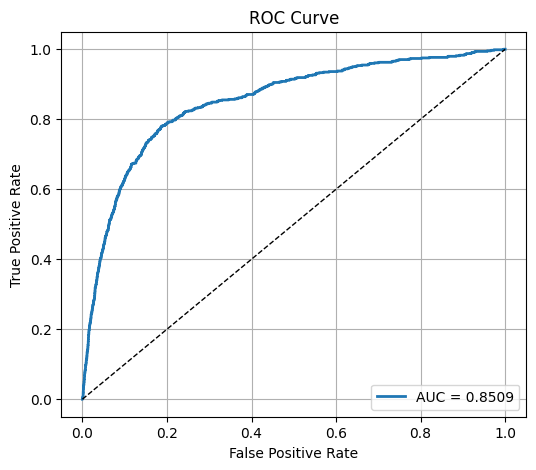

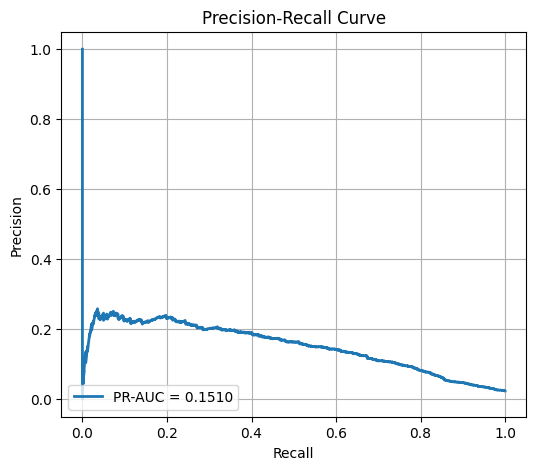

{'roc_auc': 0.8509468941309004,
 'pr_auc': 0.151035045921055,
 'precision@k': {'1': 0.0,
  '3': 0.2119700748129676,
  '5': 0.18937125748502995,
  '10': 0.14328469884025438},
 'recall@k': {'1': 0.0,
  '3': 0.26479750778816197,
  '5': 0.3940809968847352,
  '10': 0.5965732087227414,
  '20': 0.7772585669781932}}

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

def metric_report(y_true, y_pred, ks=(1, 3, 5, 10, 20)):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    roc_auc = roc_auc_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    order = np.argsort(-y_pred)
    y_true_sorted = y_true[order]

    n = len(y_true)
    total_pos = y_true.sum()

    precision_at_k = {}
    recall_at_k = {}

    for k in ks:
        if k <= 1:
            top_k = k
        else:
            top_k = int(n * (k / 100))

        top_k = max(1, top_k)
        y_top = y_true_sorted[:top_k]

        if k <= 10:
            precision_at_k[str(k)] = y_top.mean()

        if k <= 20:
            recall_at_k[str(k)] = (
                y_top.sum() / total_pos if total_pos > 0 else 0
            )

    fpr, tpr, _ = roc_curve(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", lw=2)
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, lw=2, label=f"PR-AUC = {pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.legend(loc="lower left")
    plt.show()

    return {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "precision@k": precision_at_k,
        "recall@k": recall_at_k
    }

metric_report(y_oot, y_pred_proba, ks=(1, 3, 5, 10, 20))


In [22]:
# КОМПАКТНЫЙ ВАРИАНТ
print("АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
print("="*80)
df = data
# Считаем уникальные значения для каждого признака
unique_counts = {}
for col in df.columns:
    if col.startswith('feature_'):
        unique_counts[col] = df[col].nunique()

# Группируем по количеству уникальных значений
from collections import defaultdict
count_groups = defaultdict(list)

for feature, count in unique_counts.items():
    count_groups[count].append(feature)

# Выводим результат
for num_values in range(2, 11):
    features = count_groups.get(num_values, [])
    if features:
        print(f"\nПризнаки с {num_values} уникальными значениями ({len(features)}):")
        for feature in features[:5]:  # показываем только первые 5
            print(f"  - {feature}")
            # Показываем сами значения для первых 3 признаков
            if features.index(feature) < 3:
                values = df[feature].unique()
                print(f"    Значения: {sorted(values)}")
        if len(features) > 5:
            print(f"  ... и еще {len(features) - 5} признаков")

# Самые интересные случаи
print(f"\n{'='*80}")
print("САМЫЕ ИНТЕРЕСНЫЕ СЛУЧАИ:")
print(f"{'='*80}")

for num_values in [2, 3]:
    if num_values in count_groups:
        print(f"\nБинарные/трехзначные признаки ({num_values} значения):")
        for feature in count_groups[num_values][:10]:  # первые 10
            values = df[feature].dropna().unique()
            value_counts = df[feature].value_counts()
            print(f"  {feature}:")
            print(f"    Значения: {sorted(values)}")
            print(f"    Распределение: {dict(value_counts)}")

АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Признаки с 2 уникальными значениями (477):
  - feature_0
    Значения: [-0.3618543, nan, 2.7637558]
  - feature_1
    Значения: [-0.17299719, nan, 5.780886]
  - feature_5
    Значения: [-0.20176533, nan, 4.9566345]
  - feature_7
  - feature_20
  ... и еще 472 признаков

Признаки с 3 уникальными значениями (2):
  - feature_810
    Значения: [nan, -0.003938356, 182.03108, 464.9819]
  - feature_1157
    Значения: [0.0, 1.0, 2.0]

Признаки с 4 уникальными значениями (4):
  - feature_211
    Значения: [0.0, 2.0, nan, 1.0, 3.0]
  - feature_969
    Значения: [0.0, 1.0, 2.0, 3.0]
  - feature_1001
    Значения: [nan, -0.8071072, 10.82344, 22.453987, 34.084534]
  - feature_1218

Признаки с 5 уникальными значениями (6):
  - feature_139
    Значения: [0.0, 1.0, 2.0, 3.0, 4.0]
  - feature_477
    Значения: [nan, -0.19541268, 16.066423, 32.32826, 48.590096, 64.85193]
  - feature_514
    Значения: [0.0, 1.0, 2.0, nan, 3.0, 4.0]
  - feature_733
  - feature_893
  ... и 

In [6]:
data.feature_539.value_counts()

feature_539
-0.803689     412314
 1.207996     169797
 3.219681      26301
 5.231366       4636
 7.243051        979
 9.254735        351
 11.266420       105
 15.289789        51
 13.278105        36
 17.301474        19
Name: count, dtype: int64